# PROJET 7


# IMPLEMENTER UN MODELE DE SCORING


## NOTEBOOK 2 - MODELES DE CLASSIFICATION

In [1]:
#pip install mlflow

In [2]:
#pip install catboost

In [3]:
#pip install xgboost

In [4]:
#pip install pyngrok

In [5]:
#pip install imblearn

In [31]:
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import time
import math
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import average_precision_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier

import mlflow
from mlflow.exceptions import MlflowException
from mlflow.models.signature import infer_signature
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [7]:
from pyngrok import ngrok

ngrok.kill()

NGROK_AUTH_TOKEN="2YUPWBbQP1tmCPTg1x2qVsxinj7_6j69afS3SEA4Y8fBPTCmM"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

ngrok_tunnel=ngrok.connect(addr="5000",proto="http",bind_tls=True)
print("MLFLOW Tracking UI :", ngrok_tunnel.public_url)


t=2024-01-25T10:41:42+0100 lvl=warn msg="ngrok config file found at legacy location, move to XDG location" xdg_path=C:\\Users\\helen\\AppData\\Local/ngrok/ngrok.yml legacy_path=C:\\Users\\helen\\.ngrok2\\ngrok.yml


MLFLOW Tracking UI : https://a7f2-2001-861-8c97-c270-49ab-2a6b-78af-f41a.ngrok-free.app


In [8]:
!mlflow ui

^C


## PARTIE 1 - DATA - ANALYSE DES DONNEES

In [9]:
X_train = pd.read_csv("data_work/X_train.csv", sep ='\t')
X_test = pd.read_csv("data_work/X_test.csv", sep ='\t')
y_train = pd.read_csv("data_work/y_train.csv", sep ='\t')
y_test = pd.read_csv("data_work/y_test.csv", sep ='\t')

In [10]:
import re
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [11]:
y_train=y_train['TARGET']

In [12]:
y_test=y_test['TARGET']

In [13]:
X_train.drop('Unnamed0', axis=1, inplace=True)

In [14]:
X_test.drop('Unnamed0', axis=1, inplace=True)

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((215257, 112), (215257,), (92254, 112), (92254,))

## PARTIE 3 - DEFINITION DU SCORE METIER

In [16]:
def Score_metier(y_true, y_pred, fn_value=-10, fp_value=-1, tp_value=1, tn_value=1):

    # Matrice de Confusion
    mat_conf = confusion_matrix(y_true, y_pred)
    
    # Nombre de True Negatifs
    tn = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = mat_conf[1, 0]
    # Nombre de Faux Positifs
    fp = mat_conf[0, 1]
    # Nombre de True Positifs
    tp = mat_conf[1, 1]
    
    # Gain total
    J = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value
    
    # Gain maximum
    max_J = (fp + tn)*tn_value + (fn + tp)*tp_value
    
    # Gain minimum
    min_J = (fp + tn)*fp_value + (fn + tp)*fn_value
    
    # Gain normalisé entre 0 et 1
    J_normalized = (J - min_J)/(max_J - min_J)
    
    return J_normalized  # Retourne la fonction d'évaluation

## PARTIE 2 - BASELINE

In [17]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):

    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if feature_importances : 
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]
    
        features = []
        for i in range(20):
            features.append(X_train.columns[indices[i]])

        sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
        plt.xlabel('Features importance')
        plt.xticks(rotation=90)

        show()

In [18]:
from sklearn.dummy import DummyClassifier

In [19]:
%%time
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, dummy.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, dummy.predict(X_test)))

AUC : 0.5000
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254

Wall time: 116 ms


C:\Users\helen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\helen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\helen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


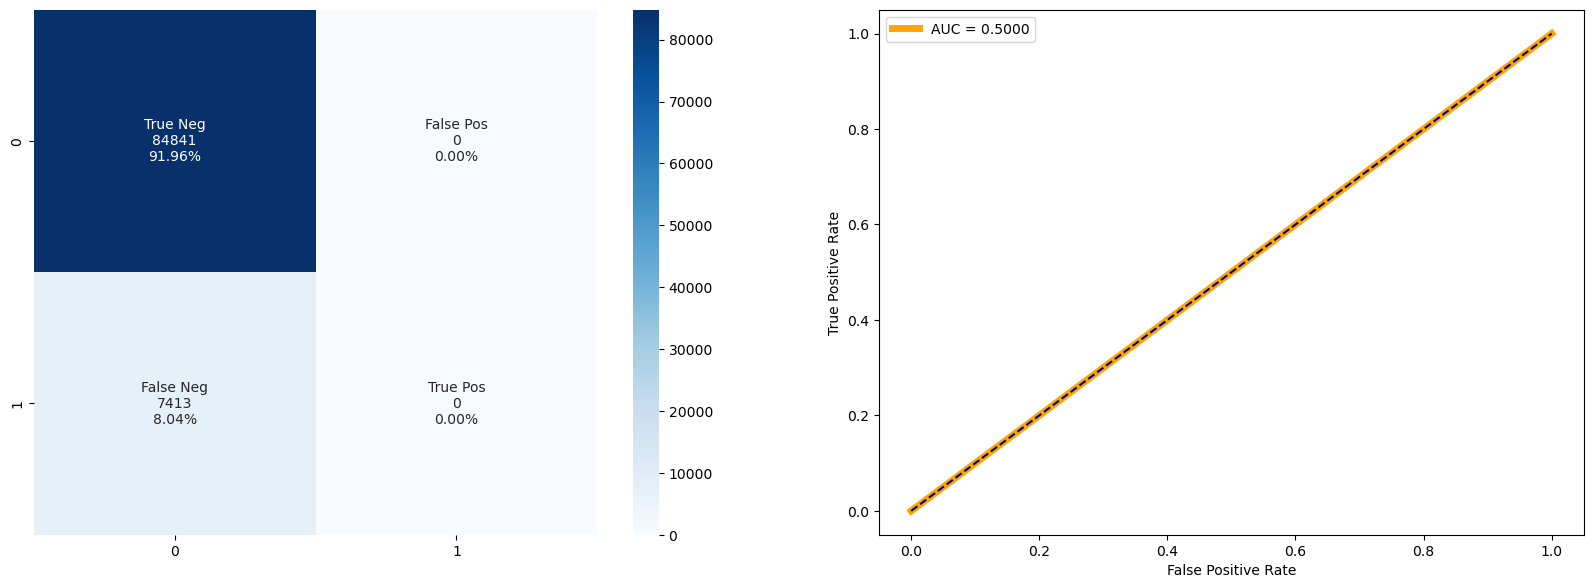

In [20]:
cf_matrix_roc_auc(dummy, y_test, dummy.predict(X_test), dummy.predict_proba(X_test)[:,1], feature_importances=None)

## PARTIE 3 - MODELES DE CLASSIFICATION

### 3 - 1 : Définition des modèles et grilles d'hyperparamètres

In [20]:
# Sur la data sans traitement de la classe minoritaire
myrunname=['KNN_best','LogisticRegression_best','CatBoostClassifier_best','LGBMClassifier_best']

# modèles
mymodels = [KNeighborsClassifier(),LogisticRegression(),CatBoostClassifier(allow_writing_files=False),LGBMClassifier(allow_writing_files=False)]


# grille d'hyperparamètres
KNN_params ={'n_neighbors':range (4, 8, 1)}
LogisticRegression_params={'max_iter':[50, 100]}
CATBOOST_params = {'depth': [4, 8, 10], 'learning_rate': [0.01,0.05],'iterations': [30,50]}
LGBM_params={'n_estimators': [200, 500],'max_depth': [3, 4],'learning_rate': [0.1, 0.01]}

mygrids = [KNN_params,LogisticRegression_params,CATBOOST_params,LGBM_params]

### 3 - Modélisation - MLFLOW

#### 3 - 1 : Modélisation sans traitement du déséquilibre des classes

C:\Users\helen\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


run_id=f72e039261fc47e397ce0b447e596070


C:\Users\helen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


run_id=a91e2578359b44b38b18f35180a9c83f
0:	learn: 0.6392173	total: 485ms	remaining: 23.7s
1:	learn: 0.5920714	total: 840ms	remaining: 20.2s
2:	learn: 0.5501866	total: 1.21s	remaining: 18.9s
3:	learn: 0.5167634	total: 1.55s	remaining: 17.8s
4:	learn: 0.4848445	total: 1.91s	remaining: 17.2s
5:	learn: 0.4584342	total: 2.24s	remaining: 16.5s
6:	learn: 0.4350224	total: 2.56s	remaining: 15.8s
7:	learn: 0.4142682	total: 2.9s	remaining: 15.2s
8:	learn: 0.3961594	total: 3.23s	remaining: 14.7s
9:	learn: 0.3809231	total: 3.58s	remaining: 14.3s
10:	learn: 0.3671804	total: 3.95s	remaining: 14s
11:	learn: 0.3544782	total: 4.42s	remaining: 14s
12:	learn: 0.3441458	total: 4.75s	remaining: 13.5s
13:	learn: 0.3335566	total: 5.1s	remaining: 13.1s
14:	learn: 0.3248509	total: 5.43s	remaining: 12.7s
15:	learn: 0.3171722	total: 5.77s	remaining: 12.3s
16:	learn: 0.3102018	total: 6.1s	remaining: 11.8s
17:	learn: 0.3035737	total: 6.47s	remaining: 11.5s
18:	learn: 0.2980745	total: 6.82s	remaining: 11.1s
19:	lear

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

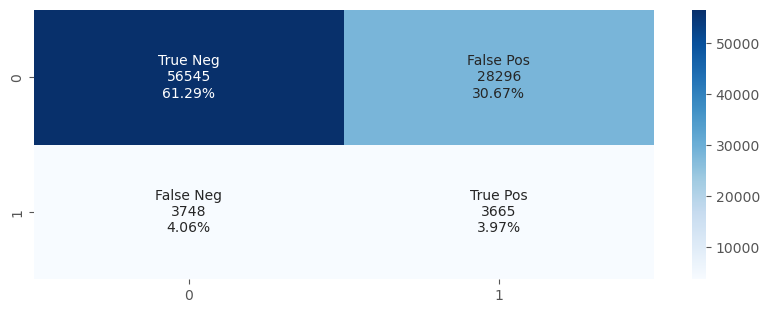

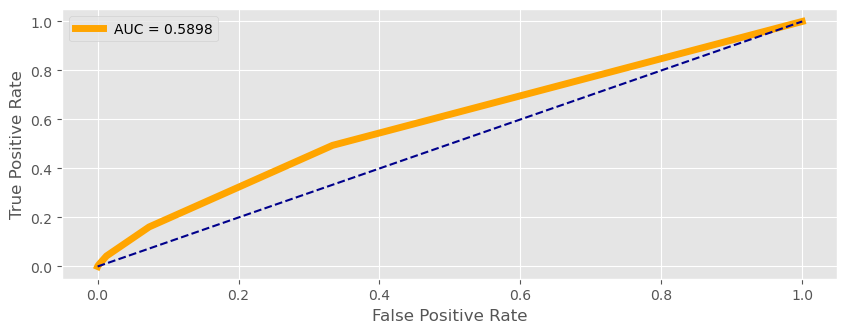

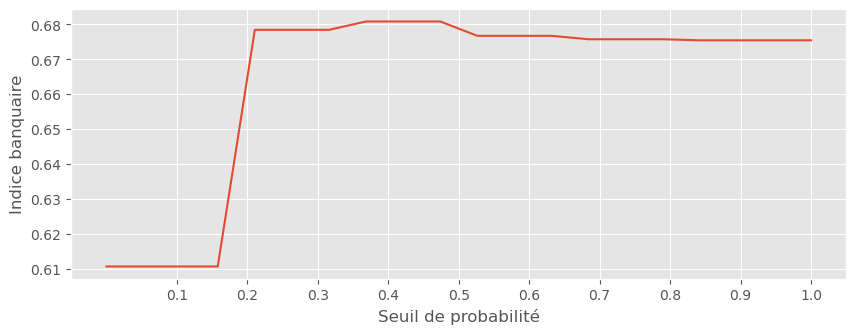

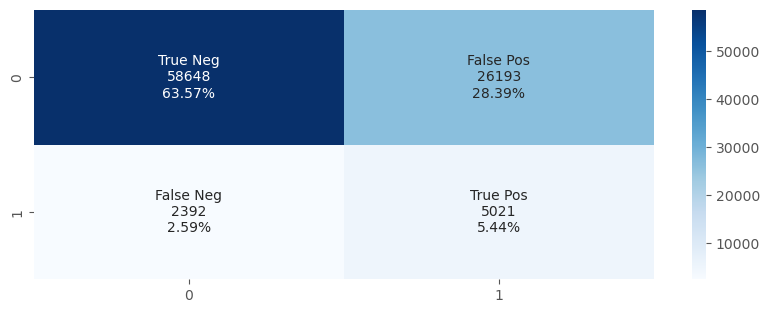

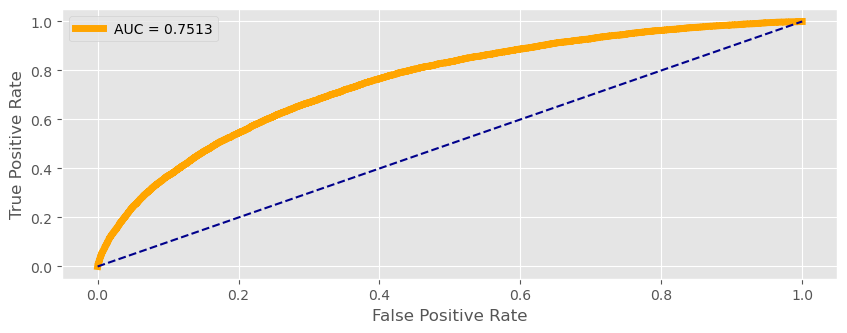

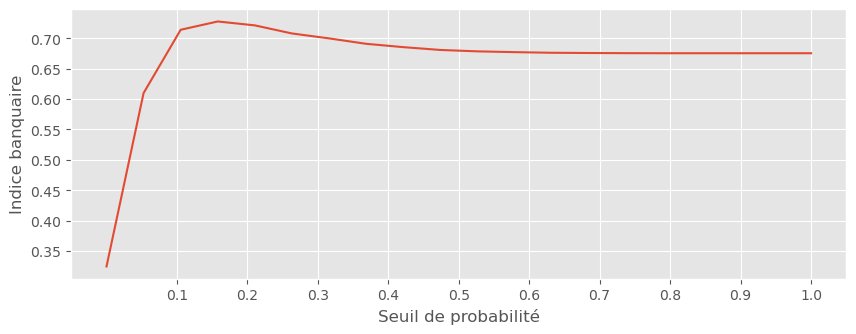

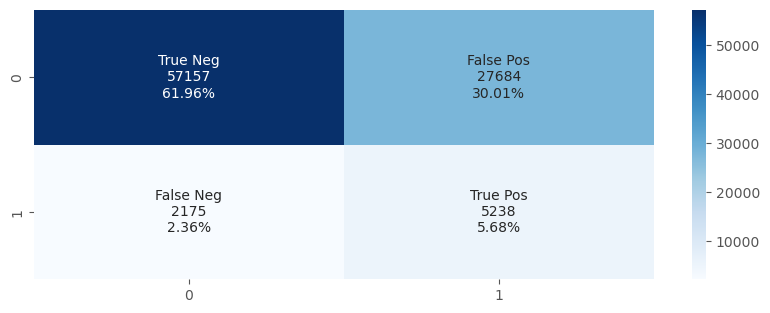

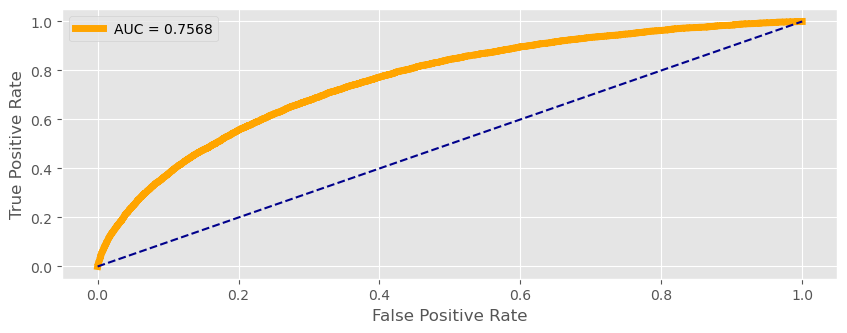

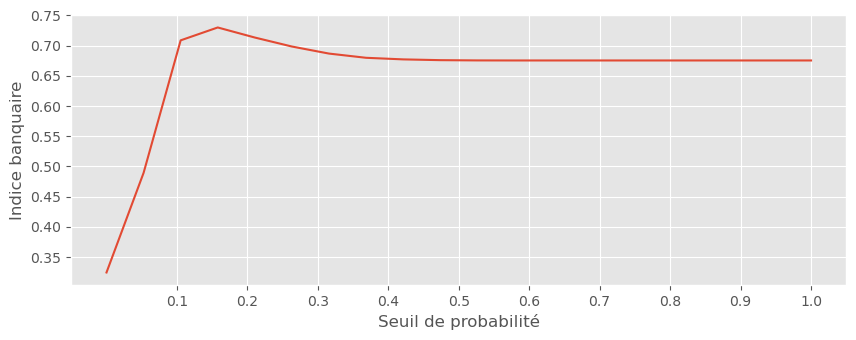

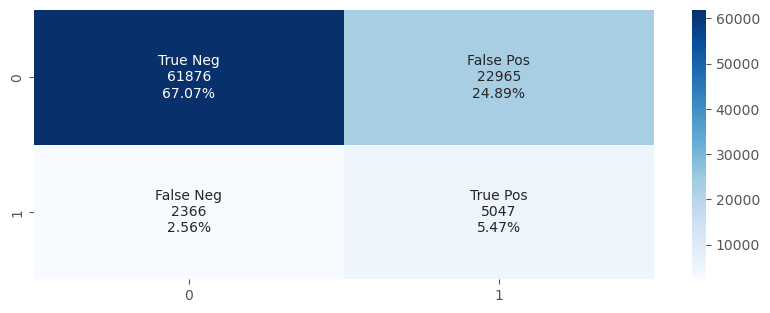

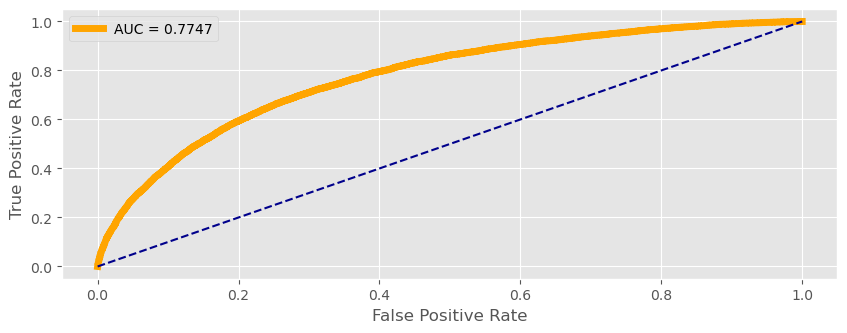

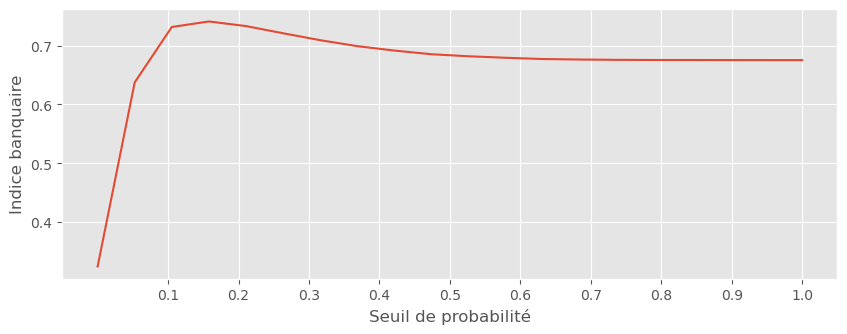

In [21]:
plt.style.use('ggplot')

experiment_name = 'Modèles de classification - Sans traitement Déséquilibre : Hyperparamètres'

if not mlflow.get_experiment_by_name(experiment_name):
    try:
        mlflow.create_experiment(experiment_name)
    except MlflowException as ex:
        print(f'{ex}')
        
#mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
#mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name)
#mlflow.sklearn.autolog()

col = 0


for elt in mymodels:

    with mlflow.start_run(run_name=myrunname[col]) as run:
        start_time = time.time()
        model = GridSearchCV(estimator=mymodels[col], param_grid=mygrids[col], n_jobs=-1, cv=15,error_score='raise')
        model.fit(X_train, y_train)
        timetrain=time.time() - start_time
        
        start_time = time.time()
        signature = infer_signature(X_train, model.predict(X_train))
        timetest=time.time() - start_time
        
        mlflow.sklearn.log_model(model, 'model', signature=signature)
        mlflow.log_params(model.best_params_)

        
        #y_train_pred = model.predict(X_train)
        #y_test_pred = model.predict(X_test)
        
        best_model = model.best_estimator_
        preds = best_model.predict_proba(X_train)[:,1]

        fpr, tpr, thresholds = roc_curve(y_train, preds)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        
        y_test_pred = [1 if i >= optimal_threshold else 0 for i in best_model.predict_proba(X_test)[:,1]]   
        y_train_pred = [1 if i >= optimal_threshold else 0 for i in best_model.predict_proba(X_train)[:,1]]          
        
        
        # Calcul des métriques techniques et métrique métier
        precision_train = precision_score(y_train, y_train_pred)
        precision_test = precision_score(y_test, y_test_pred)

        recall_train = recall_score(y_train, y_train_pred)
        recall_test = recall_score(y_test, y_test_pred)

        f1_train = f1_score(y_train, y_train_pred)
        f1_test = f1_score(y_test, y_test_pred)
        
        #f_train = (1+beta*beta)*precision_train*recall_train/(beta*beta*precision_train+recall_train)
        #f_test = (1+beta*beta)*precision_test*recall_test/(beta*beta*precision_test+recall_test) 
        
        y_train_prob = model.predict_proba(X_train)[:,1]
        y_test_prob = model.predict_proba(X_test)[:,1]

        auc_train = roc_auc_score(y_train, y_train_prob)
        auc_test = roc_auc_score(y_test, y_test_prob)
        
        
        Score_metier_train=Score_metier(y_train, y_train_pred, fn_value=-10, fp_value=-1, tp_value=1, tn_value=1)
        Score_metier_test=Score_metier(y_test, y_test_pred, fn_value=-10, fp_value=-1, tp_value=1, tn_value=1)
        
        
        perf_metrics = {
        'timetrain':timetrain,
        'timetest':timetest,            
        'precision_train': precision_train,
        'precision_test': precision_test,
        'recall_train': recall_train,
        'recall_test': recall_test,
        'f1_train': f1_train,
        'f1_test': f1_test,            
        'auc_train': auc_train,
        'auc_test': auc_test,
        'Score_metier_train':Score_metier_train,
        'Score_metier_test' :Score_metier_test,  
        'solvability_threshold':optimal_threshold}
        mlflow.log_metrics(perf_metrics)

        pd.DataFrame({k: model.cv_results_[k] for k in model.cv_results_ if k not in {'params'}}) \
            .to_csv('./mlruns/cv-results.csv', index=False)
        mlflow.log_artifact('./mlruns/cv-results.csv', 'artifact')

        # Matrice de confusion"
        fig, ax = plt.subplots(1,1, figsize=(10, 3.5))
        cf_matrix = confusion_matrix(y_test, y_test_pred)
        group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
        group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
        mlflow.log_figure(fig, 'fig/02-Matrice de confusion.png')
        
        
        # Courbe ROC AUC
        fig, ax = plt.subplots(1,1, figsize=(10, 3.5))
        fpr,tpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %auc_test)
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        mlflow.log_figure(fig, 'fig/01-ROC AUC.png')
        
        
        # Seuil de solvabilité
        fig, ax = plt.subplots(1,1, figsize=(10, 3.5))
        cost_function = []
        threshold_x = np.linspace(0.0, 1, 20)

        for threshold in threshold_x:

            # Score du modèle : 0 à 1
            y_score = best_model.predict_proba(X_test)[:, 1]

            # Score > seuil de solvabilité : retourne 1 sinon 0
            y_pred = (y_score > threshold)

            y_test_pred = np.array(y_pred > 0) * 1
            
            # Calcul de l'indice bancaire
            cost_function.append(Score_metier(y_test, y_test_pred))
            
        # Affichage du gain en fonction du seuil de solvabilité    
        plt.plot(threshold_x, cost_function)
        plt.xlabel("Seuil de probabilité")
        plt.ylabel("Indice banquaire")
        plt.xticks(np.linspace(0.1, 1, 10))       
        mlflow.log_figure(fig, 'fig/03-Seuil de solvabilité.png') 

        

        
        run_id = mlflow.active_run().info.run_id
        print(f'run_id={run_id}')
                                 
    col += 1

#### 3 - 2 : Modélisation avec traitement du déséquilibre des classes Hyperparamètres

In [45]:
# Prise en compte Déséquilibre des classes : Hyperparamètres
myrunname=['KNN_best','LogisticRegression_best','CatBoostClassifier_best','LGBMClassifier_best']

# modèles
mymodels = [KNeighborsClassifier(),LogisticRegression(class_weight={0: 1, 1: 10}),CatBoostClassifier(allow_writing_files=False),LGBMClassifier()]
positive_weight = len(y_train) / (2 * np.bincount(y_train))

# grille d'hyperparamètres
KNN_params ={'n_neighbors':range (4, 8, 1)}
LogisticRegression_params={'max_iter':[50, 100]}
CATBOOST_params = {'depth': [4, 8, 10], 'learning_rate': [0.01,0.03],'iterations': [30,50,75],'scale_pos_weight':positive_weight}
LGBM_params={'n_estimators': [200, 500],'max_depth': [3,4],'learning_rate': [0.03, 0.01],'scale_pos_weight': [2,3,4,5,6]}

mygrids = [KNN_params,LogisticRegression_params,CATBOOST_params,LGBM_params]

run_id=dfabc9a80d09413cb7f714d0fa2dfd94


C:\Users\helen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


run_id=4e50f98944fa4414b934d829f0a9eb46
0:	learn: 0.6875729	total: 728ms	remaining: 53.9s
1:	learn: 0.6825675	total: 1.29s	remaining: 47.2s
2:	learn: 0.6777442	total: 1.88s	remaining: 45.1s
3:	learn: 0.6731538	total: 2.45s	remaining: 43.6s
4:	learn: 0.6687993	total: 3.05s	remaining: 42.7s
5:	learn: 0.6648055	total: 3.6s	remaining: 41.4s
6:	learn: 0.6610646	total: 4.11s	remaining: 40s
7:	learn: 0.6573468	total: 4.65s	remaining: 39s
8:	learn: 0.6539038	total: 5.2s	remaining: 38.2s
9:	learn: 0.6505076	total: 5.75s	remaining: 37.4s
10:	learn: 0.6474274	total: 6.31s	remaining: 36.7s
11:	learn: 0.6444885	total: 6.84s	remaining: 35.9s
12:	learn: 0.6415910	total: 7.37s	remaining: 35.2s
13:	learn: 0.6388432	total: 7.93s	remaining: 34.6s
14:	learn: 0.6362100	total: 8.45s	remaining: 33.8s
15:	learn: 0.6336565	total: 9.01s	remaining: 33.2s
16:	learn: 0.6311844	total: 9.55s	remaining: 32.6s
17:	learn: 0.6290087	total: 10.1s	remaining: 31.9s
18:	learn: 0.6268133	total: 10.6s	remaining: 31.2s
19:	lea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

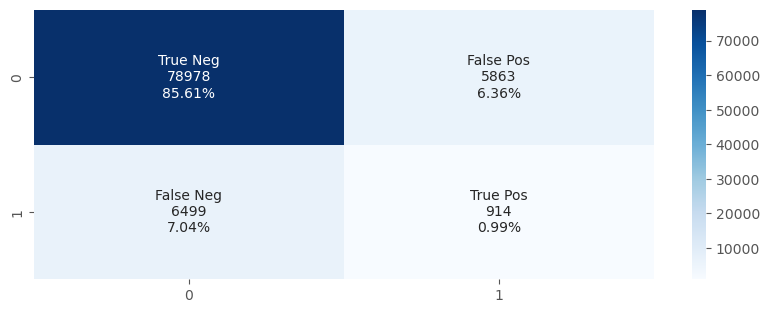

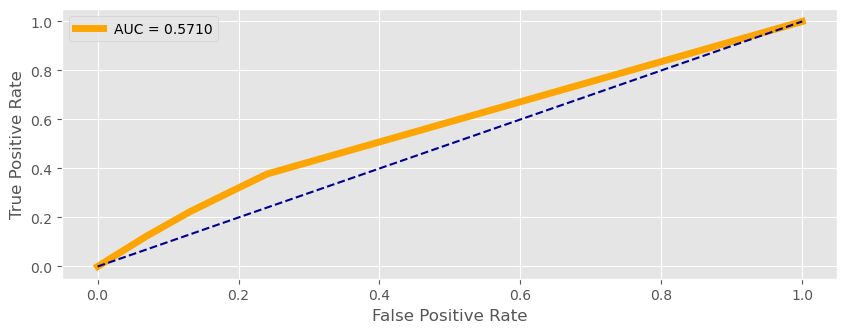

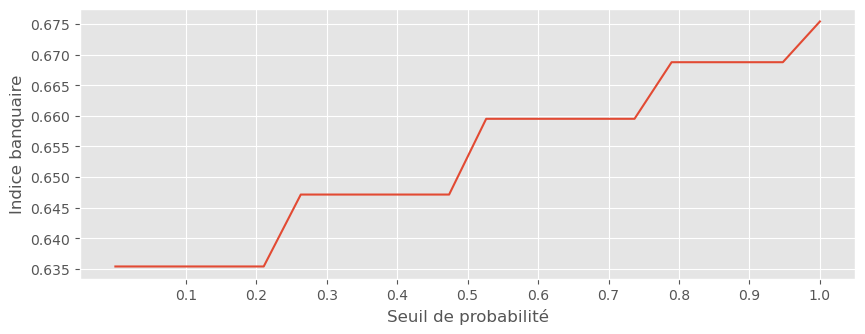

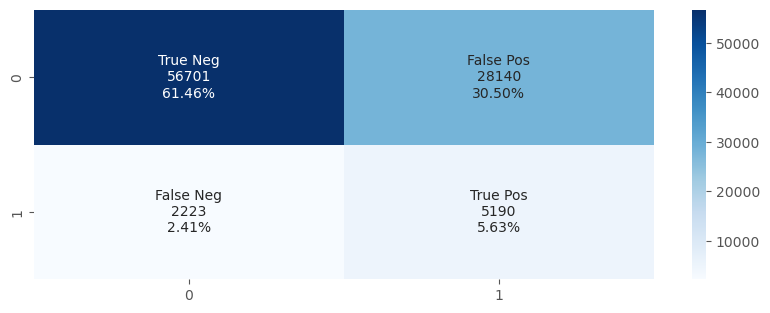

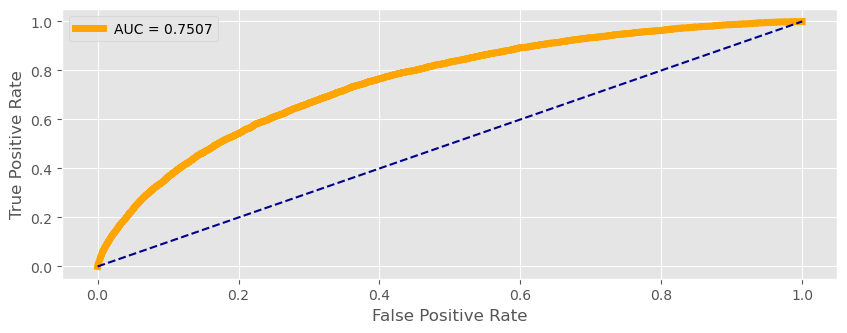

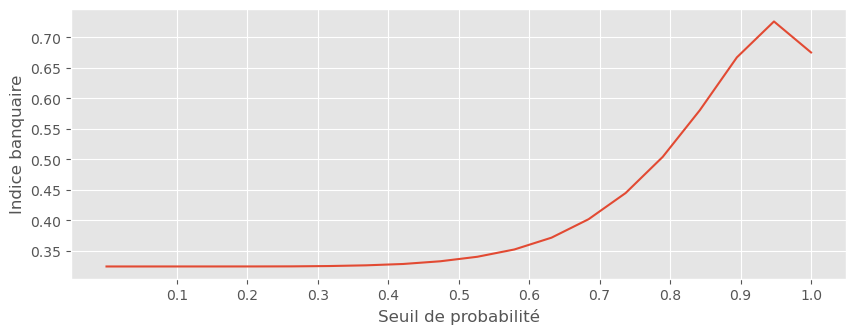

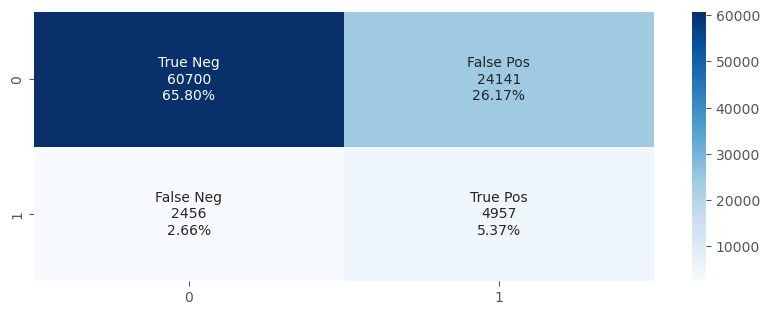

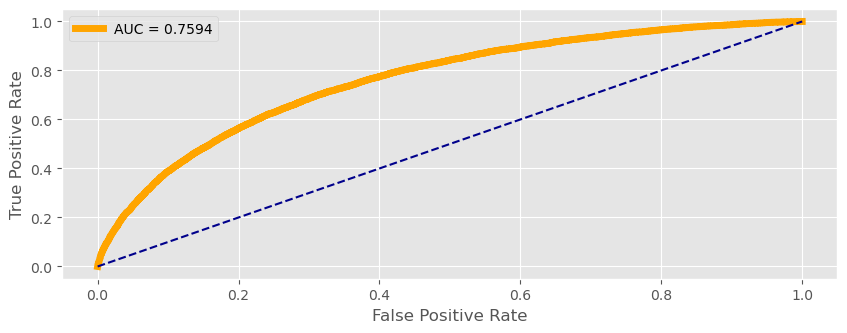

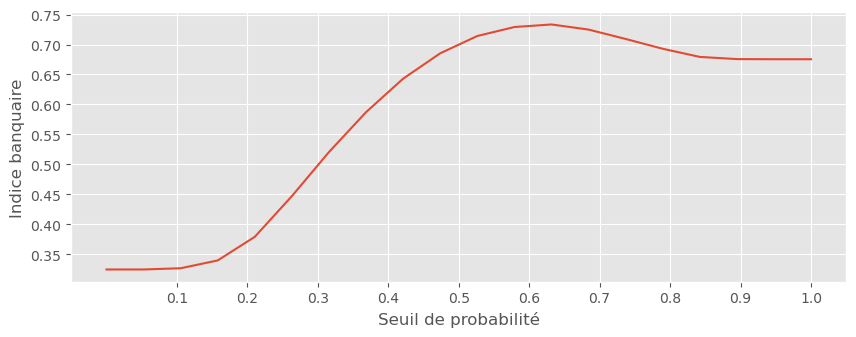

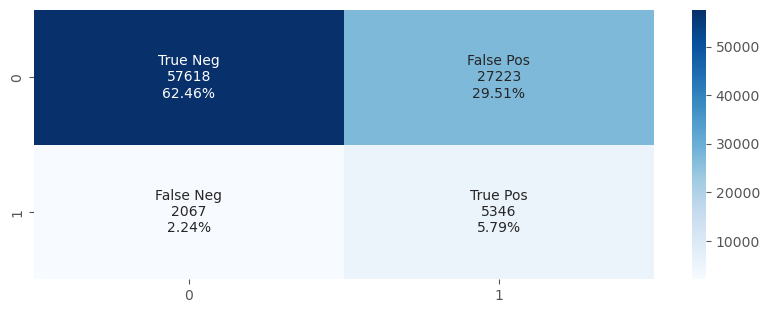

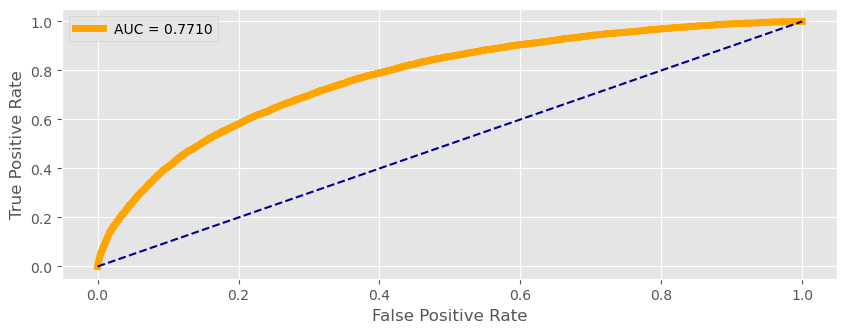

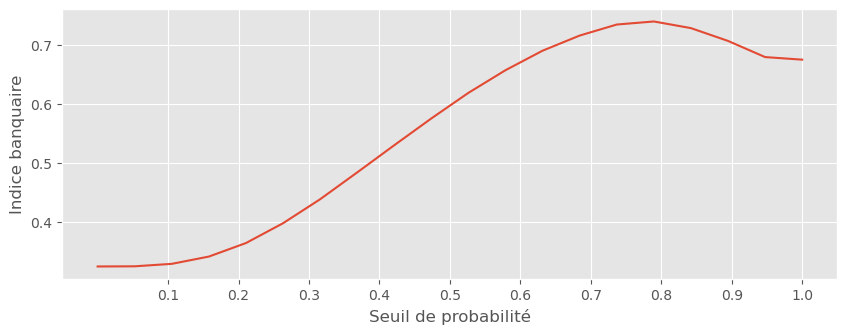

In [46]:
plt.style.use('ggplot')

experiment_name = 'Modèles de classification - Hyperparamètres'

if not mlflow.get_experiment_by_name(experiment_name):
    try:
        mlflow.create_experiment(experiment_name)
    except MlflowException as ex:
        print(f'{ex}')
        
#mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
#mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name)
#mlflow.sklearn.autolog()

col = 0


for elt in mymodels:

    with mlflow.start_run(run_name=myrunname[col]) as run:
        start_time = time.time()
        model = GridSearchCV(estimator=mymodels[col], param_grid=mygrids[col], n_jobs=-1, cv=15,error_score='raise')
        model.fit(X_train, y_train)
        timetrain=time.time() - start_time
        
        start_time = time.time()
        signature = infer_signature(X_train, model.predict(X_train))
        timetest=time.time() - start_time
        
        mlflow.sklearn.log_model(model, 'model', signature=signature)
        mlflow.log_params(model.best_params_)

        
        #y_train_pred = model.predict(X_train)
        #y_test_pred = model.predict(X_test)
        
        best_model = model.best_estimator_
        preds = best_model.predict_proba(X_train)[:,1]

        fpr, tpr, thresholds = roc_curve(y_train, preds)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        
        y_test_pred = [1 if i >= optimal_threshold else 0 for i in best_model.predict_proba(X_test)[:,1]]   
        y_train_pred = [1 if i >= optimal_threshold else 0 for i in best_model.predict_proba(X_train)[:,1]]          
        
        
        # Calcul des métriques techniques et métrique métier
        precision_train = precision_score(y_train, y_train_pred)
        precision_test = precision_score(y_test, y_test_pred)

        recall_train = recall_score(y_train, y_train_pred)
        recall_test = recall_score(y_test, y_test_pred)

        f1_train = f1_score(y_train, y_train_pred)
        f1_test = f1_score(y_test, y_test_pred)
        
        #f_train = (1+beta*beta)*precision_train*recall_train/(beta*beta*precision_train+recall_train)
        #f_test = (1+beta*beta)*precision_test*recall_test/(beta*beta*precision_test+recall_test) 
        
        y_train_prob = model.predict_proba(X_train)[:,1]
        y_test_prob = model.predict_proba(X_test)[:,1]

        auc_train = roc_auc_score(y_train, y_train_prob)
        auc_test = roc_auc_score(y_test, y_test_prob)
        
        
        Score_metier_train=Score_metier(y_train, y_train_pred, fn_value=-10, fp_value=-1, tp_value=1, tn_value=1)
        Score_metier_test=Score_metier(y_test, y_test_pred, fn_value=-10, fp_value=-1, tp_value=1, tn_value=1)
        
        
        perf_metrics = {
        'timetrain':timetrain,
        'timetest':timetest,            
        'precision_train': precision_train,
        'precision_test': precision_test,
        'recall_train': recall_train,
        'recall_test': recall_test,
        'f1_train': f1_train,
        'f1_test': f1_test,            
        'auc_train': auc_train,
        'auc_test': auc_test,
        'Score_metier_train':Score_metier_train,
        'Score_metier_test' :Score_metier_test,  
        'solvability_threshold':optimal_threshold}
        mlflow.log_metrics(perf_metrics)

        pd.DataFrame({k: model.cv_results_[k] for k in model.cv_results_ if k not in {'params'}}) \
            .to_csv('./mlruns/cv-results.csv', index=False)
        mlflow.log_artifact('./mlruns/cv-results.csv', 'artifact')

        # Matrice de confusion"
        fig, ax = plt.subplots(1,1, figsize=(10, 3.5))
        cf_matrix = confusion_matrix(y_test, y_test_pred)
        group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
        group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
        mlflow.log_figure(fig, 'fig/02-Matrice de confusion.png')
        
        
        # Courbe ROC AUC
        fig, ax = plt.subplots(1,1, figsize=(10, 3.5))
        fpr,tpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %auc_test)
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        mlflow.log_figure(fig, 'fig/01-ROC AUC.png')
        
        
        # Seuil de solvabilité
        fig, ax = plt.subplots(1,1, figsize=(10, 3.5))
        cost_function = []
        threshold_x = np.linspace(0.0, 1, 20)

        for threshold in threshold_x:

            # Score du modèle : 0 à 1
            y_score = best_model.predict_proba(X_test)[:, 1]

            # Score > seuil de solvabilité : retourne 1 sinon 0
            y_pred = (y_score > threshold)

            y_test_pred = np.array(y_pred > 0) * 1
            
            # Calcul de l'indice bancaire
            cost_function.append(Score_metier(y_test, y_test_pred))
            
        # Affichage du gain en fonction du seuil de solvabilité    
        plt.plot(threshold_x, cost_function)
        plt.xlabel("Seuil de probabilité")
        plt.ylabel("Indice banquaire")
        plt.xticks(np.linspace(0.1, 1, 10))       
        mlflow.log_figure(fig, 'fig/03-Seuil de solvabilité.png') 

        

        
        run_id = mlflow.active_run().info.run_id
        print(f'run_id={run_id}')
                                 
    col += 1

#### 3 - 3 : Modélisation avec traitement du déséquilibre des classes OVERSAMPLING

In [21]:
# Sur la data sans traitement de la classe minoritaire
myrunname=['KNN_best','LogisticRegression_best','CatBoostClassifier_best','LGBMClassifier_best']

# modèles
mymodels = [KNeighborsClassifier(),LogisticRegression(),CatBoostClassifier(allow_writing_files=False),LGBMClassifier(allow_writing_files=False)]


# grille d'hyperparamètres
KNN_params ={'n_neighbors':range (4, 8, 1)}
LogisticRegression_params={'max_iter':[50, 100]}
CATBOOST_params = {'depth': [4, 8, 10], 'learning_rate': [0.01,0.05],'iterations': [30,50]}
LGBM_params={'n_estimators': [200, 500],'max_depth': [3, 4],'learning_rate': [0.1, 0.01]}

mygrids = [KNN_params,LogisticRegression_params,CATBOOST_params,LGBM_params]

In [22]:
over = RandomOverSampler()
X_train_over, y_train_over = over.fit_resample(X_train, y_train)

In [23]:
X_train = X_train_over.copy()
y_train = y_train_over.copy()

C:\Users\helen\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


run_id=38a03c59307f4b03acbceb6fad34ac18


C:\Users\helen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


run_id=1371196489874271a8c67ef6c27ae435
0:	learn: 0.6839614	total: 560ms	remaining: 27.4s
1:	learn: 0.6761797	total: 1.01s	remaining: 24.2s
2:	learn: 0.6687727	total: 1.46s	remaining: 22.8s
3:	learn: 0.6620105	total: 1.87s	remaining: 21.5s
4:	learn: 0.6556323	total: 2.27s	remaining: 20.4s
5:	learn: 0.6499036	total: 2.66s	remaining: 19.5s
6:	learn: 0.6448664	total: 2.99s	remaining: 18.4s
7:	learn: 0.6401668	total: 3.33s	remaining: 17.5s
8:	learn: 0.6358960	total: 3.67s	remaining: 16.7s
9:	learn: 0.6319231	total: 4.01s	remaining: 16s
10:	learn: 0.6281485	total: 4.36s	remaining: 15.4s
11:	learn: 0.6243632	total: 4.68s	remaining: 14.8s
12:	learn: 0.6206049	total: 5.03s	remaining: 14.3s
13:	learn: 0.6175042	total: 5.37s	remaining: 13.8s
14:	learn: 0.6146767	total: 5.7s	remaining: 13.3s
15:	learn: 0.6119495	total: 6.07s	remaining: 12.9s
16:	learn: 0.6091894	total: 6.44s	remaining: 12.5s
17:	learn: 0.6069402	total: 6.82s	remaining: 12.1s
18:	learn: 0.6045975	total: 7.21s	remaining: 11.8s
19:	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Unknown parameter: allow_writing_files
run_id=d2607ade4ec644e0bcb7b0644fa5b84a


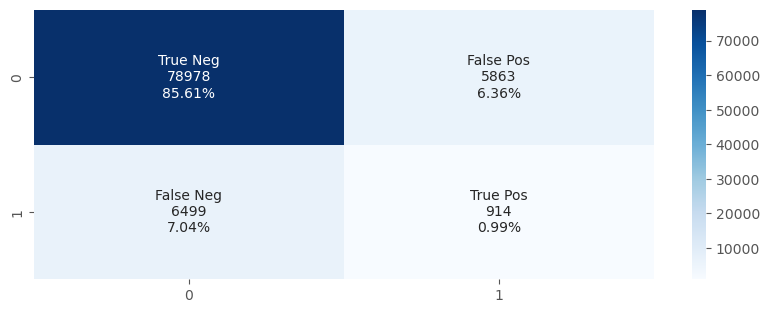

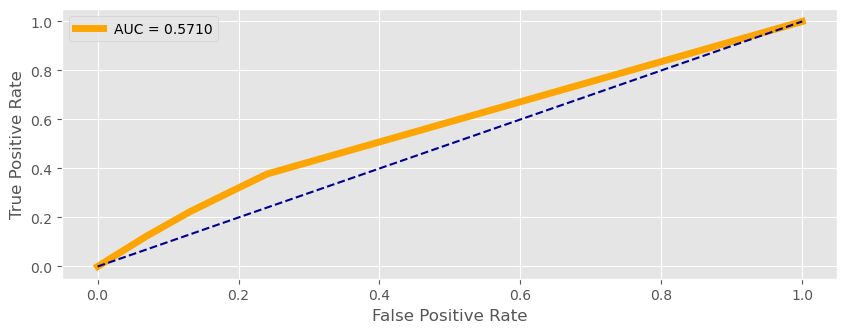

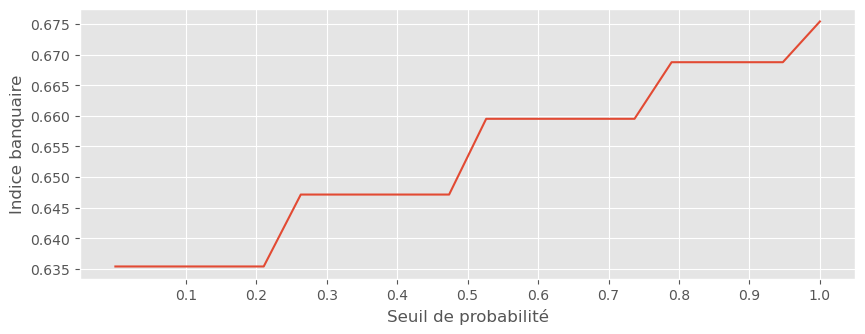

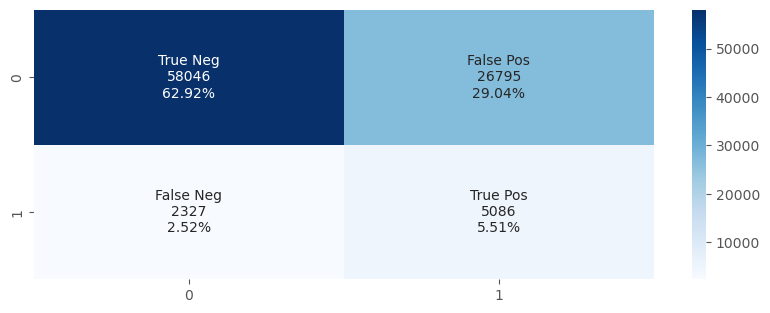

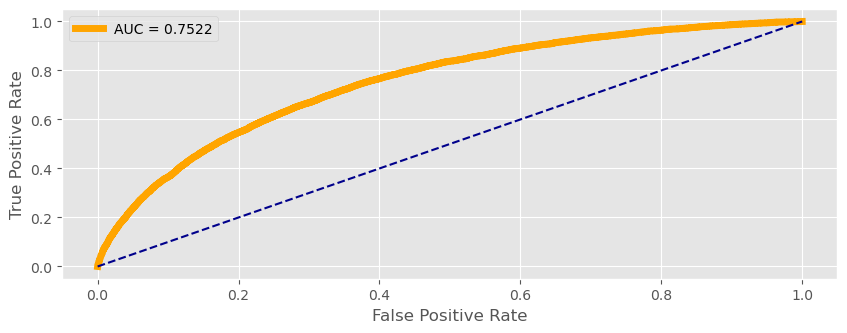

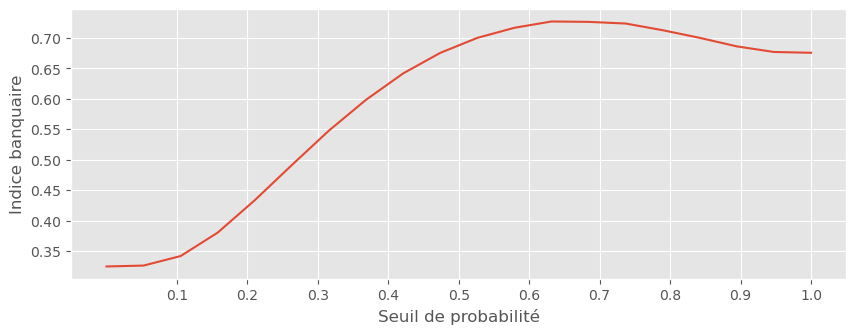

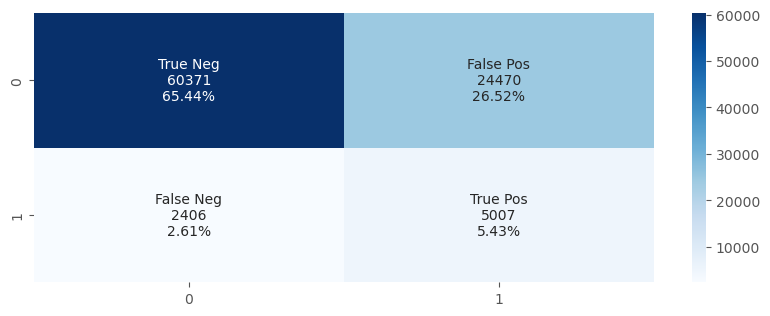

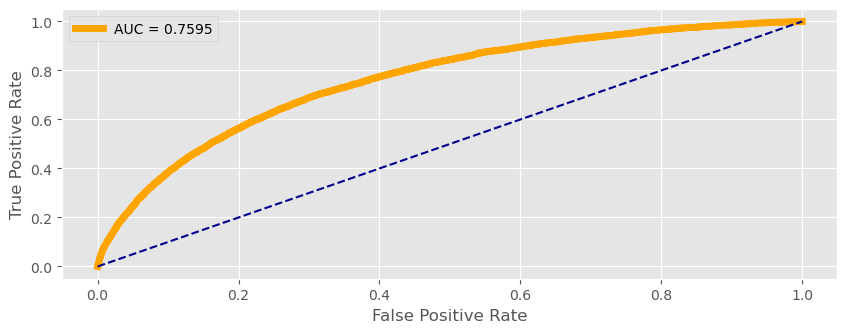

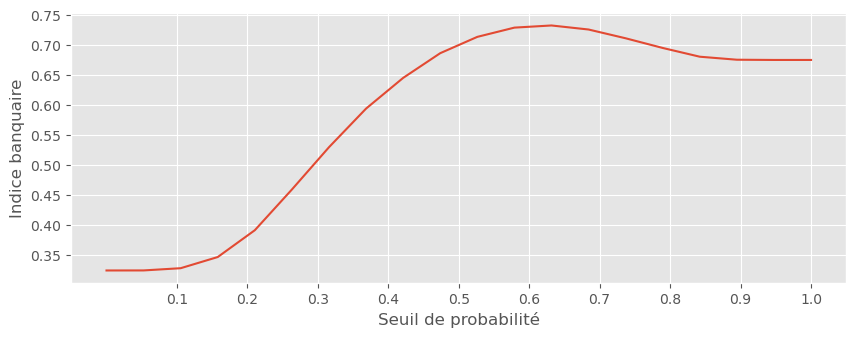

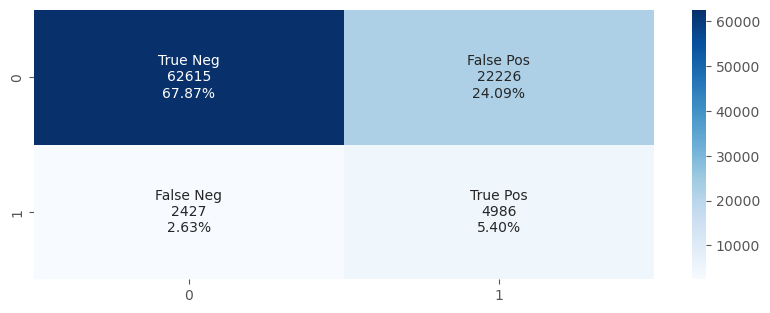

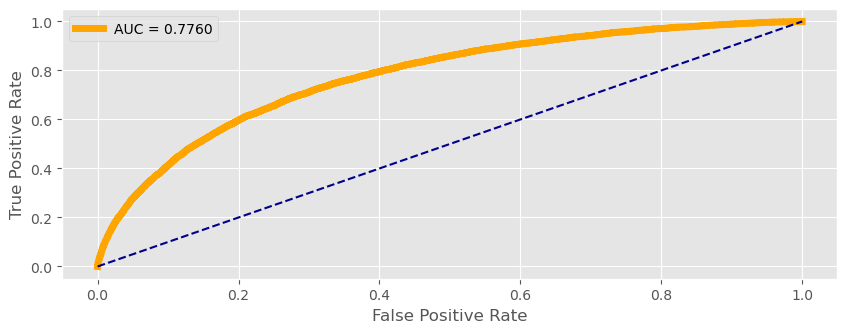

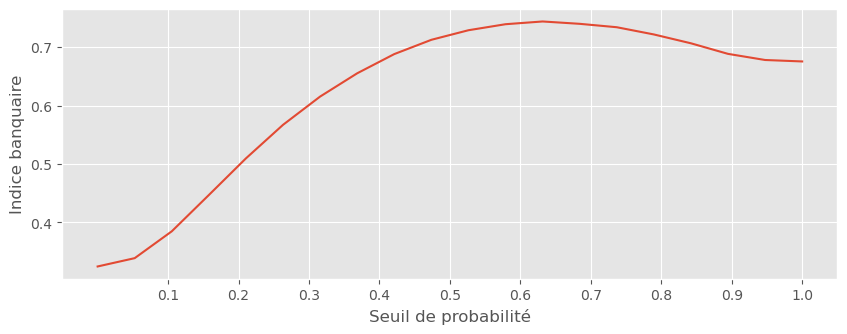

In [24]:
plt.style.use('ggplot')

experiment_name = 'Modèles de classification - Avec traitement Déséquilibre : Oversampling'

if not mlflow.get_experiment_by_name(experiment_name):
    try:
        mlflow.create_experiment(experiment_name)
    except MlflowException as ex:
        print(f'{ex}')
        
#mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
#mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name)
#mlflow.sklearn.autolog()

col = 0


for elt in mymodels:

    with mlflow.start_run(run_name=myrunname[col]) as run:
        start_time = time.time()
        model = GridSearchCV(estimator=mymodels[col], param_grid=mygrids[col], n_jobs=-1, cv=15,error_score='raise')
        model.fit(X_train, y_train)
        timetrain=time.time() - start_time
        
        start_time = time.time()
        signature = infer_signature(X_train, model.predict(X_train))
        timetest=time.time() - start_time
        
        mlflow.sklearn.log_model(model, 'model', signature=signature)
        mlflow.log_params(model.best_params_)

        
        #y_train_pred = model.predict(X_train)
        #y_test_pred = model.predict(X_test)
        
        best_model = model.best_estimator_
        preds = best_model.predict_proba(X_train)[:,1]

        fpr, tpr, thresholds = roc_curve(y_train, preds)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        
        y_test_pred = [1 if i >= optimal_threshold else 0 for i in best_model.predict_proba(X_test)[:,1]]   
        y_train_pred = [1 if i >= optimal_threshold else 0 for i in best_model.predict_proba(X_train)[:,1]]          
        
        
        # Calcul des métriques techniques et métrique métier
        precision_train = precision_score(y_train, y_train_pred)
        precision_test = precision_score(y_test, y_test_pred)

        recall_train = recall_score(y_train, y_train_pred)
        recall_test = recall_score(y_test, y_test_pred)

        f1_train = f1_score(y_train, y_train_pred)
        f1_test = f1_score(y_test, y_test_pred)
        
        #f_train = (1+beta*beta)*precision_train*recall_train/(beta*beta*precision_train+recall_train)
        #f_test = (1+beta*beta)*precision_test*recall_test/(beta*beta*precision_test+recall_test) 
        
        y_train_prob = model.predict_proba(X_train)[:,1]
        y_test_prob = model.predict_proba(X_test)[:,1]

        auc_train = roc_auc_score(y_train, y_train_prob)
        auc_test = roc_auc_score(y_test, y_test_prob)
        
        
        Score_metier_train=Score_metier(y_train, y_train_pred, fn_value=-10, fp_value=-1, tp_value=1, tn_value=1)
        Score_metier_test=Score_metier(y_test, y_test_pred, fn_value=-10, fp_value=-1, tp_value=1, tn_value=1)
        
        
        perf_metrics = {
        'timetrain':timetrain,
        'timetest':timetest,            
        'precision_train': precision_train,
        'precision_test': precision_test,
        'recall_train': recall_train,
        'recall_test': recall_test,
        'f1_train': f1_train,
        'f1_test': f1_test,            
        'auc_train': auc_train,
        'auc_test': auc_test,
        'Score_metier_train':Score_metier_train,
        'Score_metier_test' :Score_metier_test,  
        'solvability_threshold':optimal_threshold}
        mlflow.log_metrics(perf_metrics)

        pd.DataFrame({k: model.cv_results_[k] for k in model.cv_results_ if k not in {'params'}}) \
            .to_csv('./mlruns/cv-results.csv', index=False)
        mlflow.log_artifact('./mlruns/cv-results.csv', 'artifact')

        # Matrice de confusion"
        fig, ax = plt.subplots(1,1, figsize=(10, 3.5))
        cf_matrix = confusion_matrix(y_test, y_test_pred)
        group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
        group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
        mlflow.log_figure(fig, 'fig/02-Matrice de confusion.png')
        
        
        # Courbe ROC AUC
        fig, ax = plt.subplots(1,1, figsize=(10, 3.5))
        fpr,tpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %auc_test)
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        mlflow.log_figure(fig, 'fig/01-ROC AUC.png')
        
        
        # Seuil de solvabilité
        fig, ax = plt.subplots(1,1, figsize=(10, 3.5))
        cost_function = []
        threshold_x = np.linspace(0.0, 1, 20)

        for threshold in threshold_x:

            # Score du modèle : 0 à 1
            y_score = best_model.predict_proba(X_test)[:, 1]

            # Score > seuil de solvabilité : retourne 1 sinon 0
            y_pred = (y_score > threshold)

            y_test_pred = np.array(y_pred > 0) * 1
            
            # Calcul de l'indice bancaire
            cost_function.append(Score_metier(y_test, y_test_pred))
            
        # Affichage du gain en fonction du seuil de solvabilité    
        plt.plot(threshold_x, cost_function)
        plt.xlabel("Seuil de probabilité")
        plt.ylabel("Indice banquaire")
        plt.xticks(np.linspace(0.1, 1, 10))       
        mlflow.log_figure(fig, 'fig/03-Seuil de solvabilité.png') 

        

        
        run_id = mlflow.active_run().info.run_id
        print(f'run_id={run_id}')
                                 
    col += 1

#### 3 - 4 : Modélisation avec traitement du déséquilibre des classes UNDERSAMPLING

In [25]:
# Sur la data sans traitement de la classe minoritaire
myrunname=['KNN_best','LogisticRegression_best','CatBoostClassifier_best','LGBMClassifier_best']

# modèles
mymodels = [KNeighborsClassifier(),LogisticRegression(),CatBoostClassifier(allow_writing_files=False),LGBMClassifier(allow_writing_files=False)]


# grille d'hyperparamètres
KNN_params ={'n_neighbors':range (4, 8, 1)}
LogisticRegression_params={'max_iter':[50, 100]}
CATBOOST_params = {'depth': [4, 8, 10], 'learning_rate': [0.01,0.05],'iterations': [30,50]}
LGBM_params={'n_estimators': [200, 500],'max_depth': [3, 4],'learning_rate': [0.1, 0.01]}

mygrids = [KNN_params,LogisticRegression_params,CATBOOST_params,LGBM_params]

In [26]:
under = RandomUnderSampler()
X_train_under, y_train_under = under.fit_resample(X_train, y_train)

In [27]:
X_train = X_train_under.copy()
y_train = y_train_under.copy()

run_id=79a20406ed124a599d5a2ffb55b52c5f


C:\Users\helen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


run_id=0aa0051d7df84007b1df692d6e8806d8
0:	learn: 0.6839762	total: 414ms	remaining: 20.3s
1:	learn: 0.6760434	total: 789ms	remaining: 18.9s
2:	learn: 0.6686594	total: 1.17s	remaining: 18.4s
3:	learn: 0.6615779	total: 1.56s	remaining: 17.9s
4:	learn: 0.6553942	total: 1.94s	remaining: 17.4s
5:	learn: 0.6498371	total: 2.32s	remaining: 17s
6:	learn: 0.6448736	total: 2.68s	remaining: 16.4s
7:	learn: 0.6400084	total: 3.04s	remaining: 16s
8:	learn: 0.6356644	total: 3.38s	remaining: 15.4s
9:	learn: 0.6315868	total: 3.74s	remaining: 15s
10:	learn: 0.6278579	total: 4.1s	remaining: 14.5s
11:	learn: 0.6243665	total: 4.47s	remaining: 14.1s
12:	learn: 0.6205955	total: 4.86s	remaining: 13.8s
13:	learn: 0.6175819	total: 5.25s	remaining: 13.5s
14:	learn: 0.6146024	total: 5.63s	remaining: 13.1s
15:	learn: 0.6117717	total: 6.01s	remaining: 12.8s
16:	learn: 0.6091868	total: 6.37s	remaining: 12.4s
17:	learn: 0.6068086	total: 6.75s	remaining: 12s
18:	learn: 0.6044317	total: 7.13s	remaining: 11.6s
19:	learn:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Unknown parameter: allow_writing_files
[LightGBM] [Warning] Unknown parameter: allow_writing_files
[LightGBM] [Warning] Unknown parameter: allow_writing_files
[LightGBM] [Warning] Unknown parameter: allow_writing_files
[LightGBM] [Warning] Unknown parameter: allow_writing_files
[LightGBM] [Warning] Unknown parameter: allow_writing_files
[LightGBM] [Warning] Unknown parameter: allow_writing_files
[LightGBM] [Warning] Unknown parameter: allow_writing_files
[LightGBM] [Warning] Unknown parameter: allow_writing_files
[LightGBM] [Warning] Unknown parameter: allow_writing_files
[LightGBM] [Warning] Unknown parameter: allow_writing_files
[LightGBM] [Warning] Unknown parameter: allow_writing_files
run_id=c49c004b446448f7830492b484f94fd2


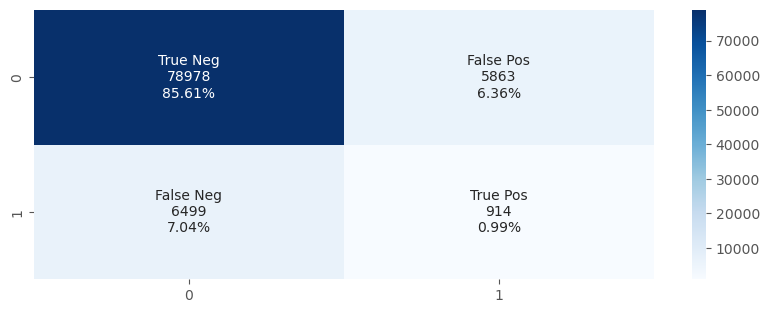

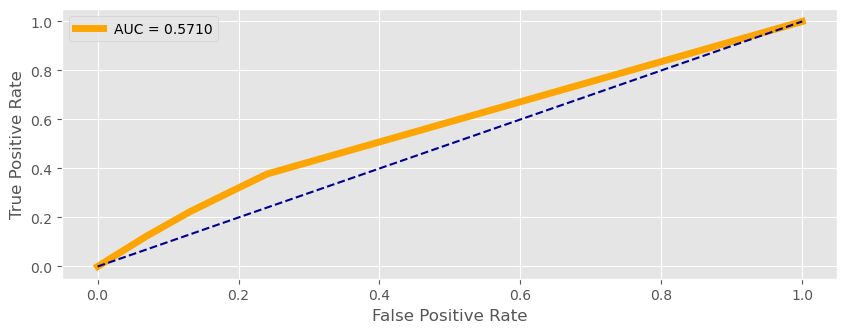

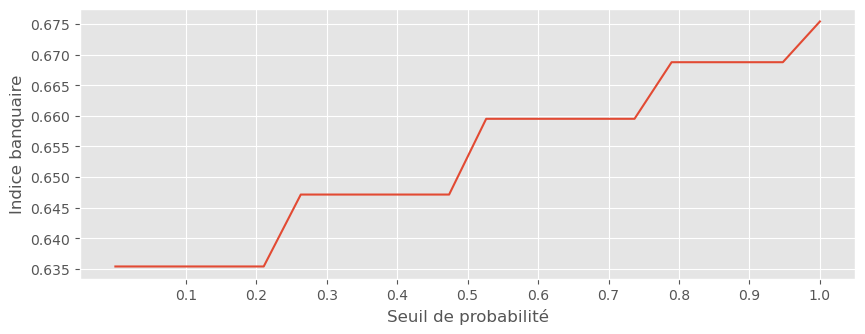

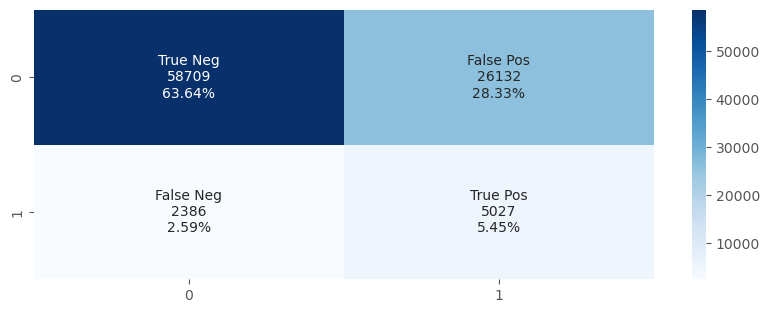

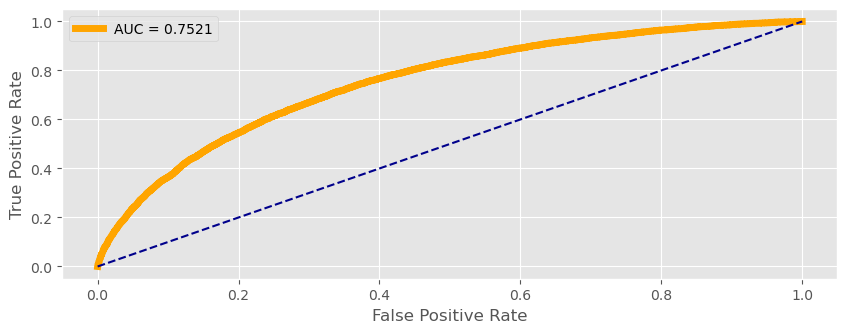

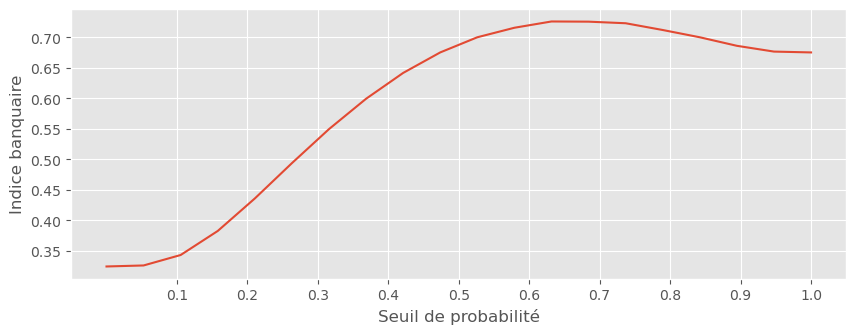

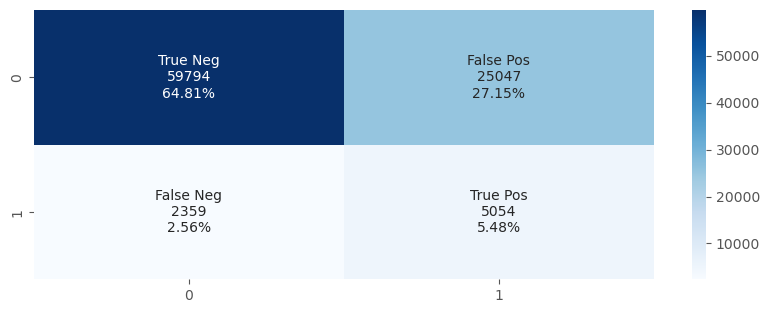

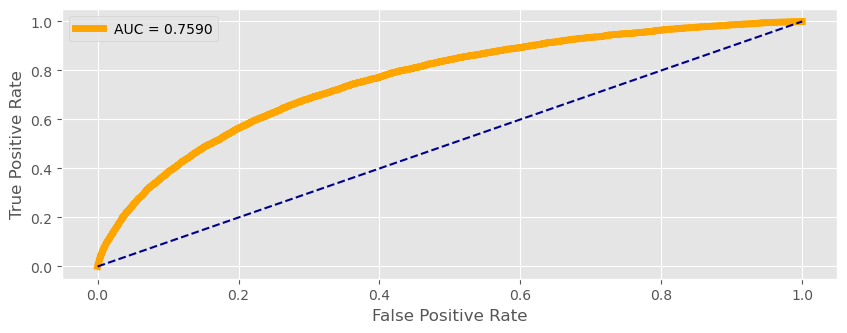

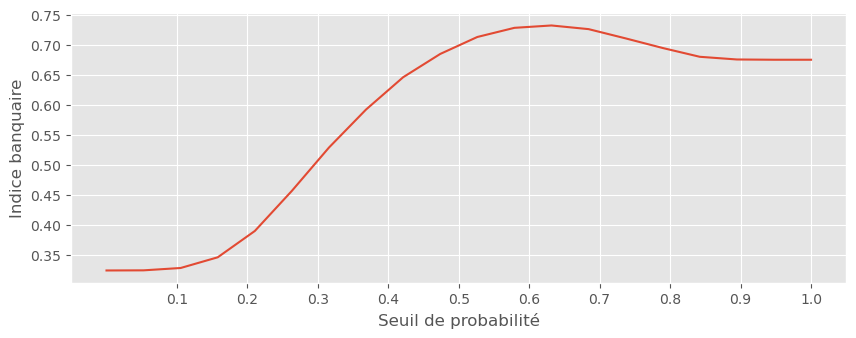

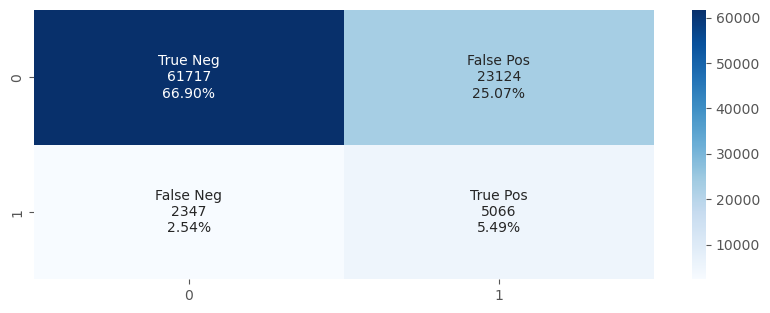

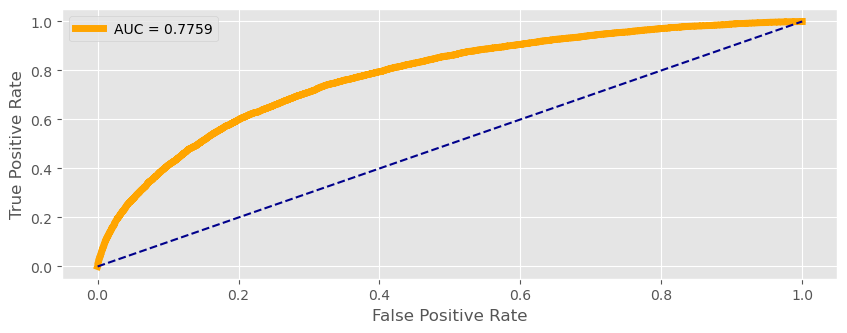

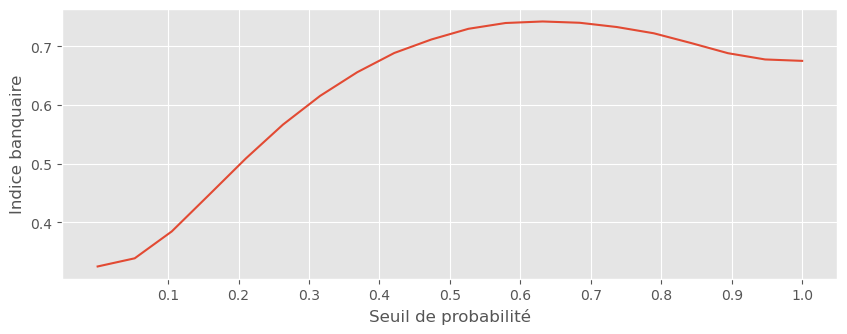

In [28]:
plt.style.use('ggplot')

experiment_name = 'Modèles de classification - Avec traitement Déséquilibre : Undersampling'

if not mlflow.get_experiment_by_name(experiment_name):
    try:
        mlflow.create_experiment(experiment_name)
    except MlflowException as ex:
        print(f'{ex}')
        
#mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
#mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name)
#mlflow.sklearn.autolog()

col = 0


for elt in mymodels:

    with mlflow.start_run(run_name=myrunname[col]) as run:
        start_time = time.time()
        model = GridSearchCV(estimator=mymodels[col], param_grid=mygrids[col], n_jobs=-1, cv=15,error_score='raise')
        model.fit(X_train, y_train)
        timetrain=time.time() - start_time
        
        start_time = time.time()
        signature = infer_signature(X_train, model.predict(X_train))
        timetest=time.time() - start_time
        
        mlflow.sklearn.log_model(model, 'model', signature=signature)
        mlflow.log_params(model.best_params_)

        
        #y_train_pred = model.predict(X_train)
        #y_test_pred = model.predict(X_test)
        
        best_model = model.best_estimator_
        preds = best_model.predict_proba(X_train)[:,1]

        fpr, tpr, thresholds = roc_curve(y_train, preds)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        
        y_test_pred = [1 if i >= optimal_threshold else 0 for i in best_model.predict_proba(X_test)[:,1]]   
        y_train_pred = [1 if i >= optimal_threshold else 0 for i in best_model.predict_proba(X_train)[:,1]]          
        
        
        # Calcul des métriques techniques et métrique métier
        precision_train = precision_score(y_train, y_train_pred)
        precision_test = precision_score(y_test, y_test_pred)

        recall_train = recall_score(y_train, y_train_pred)
        recall_test = recall_score(y_test, y_test_pred)

        f1_train = f1_score(y_train, y_train_pred)
        f1_test = f1_score(y_test, y_test_pred)
        
        #f_train = (1+beta*beta)*precision_train*recall_train/(beta*beta*precision_train+recall_train)
        #f_test = (1+beta*beta)*precision_test*recall_test/(beta*beta*precision_test+recall_test) 
        
        y_train_prob = model.predict_proba(X_train)[:,1]
        y_test_prob = model.predict_proba(X_test)[:,1]

        auc_train = roc_auc_score(y_train, y_train_prob)
        auc_test = roc_auc_score(y_test, y_test_prob)
        
        
        Score_metier_train=Score_metier(y_train, y_train_pred, fn_value=-10, fp_value=-1, tp_value=1, tn_value=1)
        Score_metier_test=Score_metier(y_test, y_test_pred, fn_value=-10, fp_value=-1, tp_value=1, tn_value=1)
        
        
        perf_metrics = {
        'timetrain':timetrain,
        'timetest':timetest,            
        'precision_train': precision_train,
        'precision_test': precision_test,
        'recall_train': recall_train,
        'recall_test': recall_test,
        'f1_train': f1_train,
        'f1_test': f1_test,            
        'auc_train': auc_train,
        'auc_test': auc_test,
        'Score_metier_train':Score_metier_train,
        'Score_metier_test' :Score_metier_test,  
        'solvability_threshold':optimal_threshold}
        mlflow.log_metrics(perf_metrics)

        pd.DataFrame({k: model.cv_results_[k] for k in model.cv_results_ if k not in {'params'}}) \
            .to_csv('./mlruns/cv-results.csv', index=False)
        mlflow.log_artifact('./mlruns/cv-results.csv', 'artifact')

        # Matrice de confusion"
        fig, ax = plt.subplots(1,1, figsize=(10, 3.5))
        cf_matrix = confusion_matrix(y_test, y_test_pred)
        group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
        group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
        mlflow.log_figure(fig, 'fig/02-Matrice de confusion.png')
        
        
        # Courbe ROC AUC
        fig, ax = plt.subplots(1,1, figsize=(10, 3.5))
        fpr,tpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %auc_test)
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        mlflow.log_figure(fig, 'fig/01-ROC AUC.png')
        
        
        # Seuil de solvabilité
        fig, ax = plt.subplots(1,1, figsize=(10, 3.5))
        cost_function = []
        threshold_x = np.linspace(0.0, 1, 20)

        for threshold in threshold_x:

            # Score du modèle : 0 à 1
            y_score = best_model.predict_proba(X_test)[:, 1]

            # Score > seuil de solvabilité : retourne 1 sinon 0
            y_pred = (y_score > threshold)

            y_test_pred = np.array(y_pred > 0) * 1
            
            # Calcul de l'indice bancaire
            cost_function.append(Score_metier(y_test, y_test_pred))
            
        # Affichage du gain en fonction du seuil de solvabilité    
        plt.plot(threshold_x, cost_function)
        plt.xlabel("Seuil de probabilité")
        plt.ylabel("Indice banquaire")
        plt.xticks(np.linspace(0.1, 1, 10))       
        mlflow.log_figure(fig, 'fig/03-Seuil de solvabilité.png') 

        

        
        run_id = mlflow.active_run().info.run_id
        print(f'run_id={run_id}')
                                 
    col += 1